In [1]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
import spatialpy
import numpy
import matplotlib.pyplot as plt
import math

In [2]:
class Walls(spatialpy.Geometry):
    ''' Outside of the unit square'''
    def inside(self, point, on_boundary):
        if point[0] < 0.0 or point[0] > 1.0 or \
           point[1] < 0.0 or point[1] > 1.0:
            return True
        return False

In [3]:
class ChemicalGradient(spatialpy.Model):
    FLUID = "Fluid"
    WALLS = Walls.__name__
    
    def __init__(self):
        spatialpy.Model.__init__(self, "Chemical Gradient")
        
        # System constants
        D = 0.1               # diffusion constant of the chemical species
        cLow = 50             # low value for boundary condition concentration
        cHigh = 100           # high value for boundary condition concentration
        
        nxF, nyF = 50, 50     # number of fluid particles in x and y-direction
        nu  = 1.0             # fluid viscosity
        L   = 1.0             # characteristic lenght of the cavity (= width = height)
        nW  = 2               # number of wall points
        rho = 1.0             # fluid density

        # Discretization
        nxTot = nxF + 2 * nW  # total number of particles in x-direction (including walls)
        nyTot = nyF + 2 * nW  # total number of particles in y-direction (including walls)
        
        # Compute domain bounds (including the boundary)
        dx, dy = L / (nxF - 1), L / (nyF - 1)
        xLim = ((0 - (nW - 1) * dx), 1 + (nW - 1) * dx)
        yLim = ((0 - (nW - 1) * dy), 1 + (nW - 1) * dy)
        
        # Compute volume and mass per particle
        # in 2D simulations, consider z-lenght = 1
        vol = (xLim[1] - xLim[0]) * (yLim[1] - yLim[0]) * 1.0
        # density * total volume / total number of particles
        mPP = rho * vol / (nxTot * nyTot)
        
        # Create domain object
        print(f"xlim={xLim} ylim={yLim} nx={nxTot} ny={nyTot}")
        domain = spatialpy.Domain.create_2D_domain(
            xLim ,yLim , nxTot, nyTot, type_id=self.FLUID, mass=mPP, nu = nu, fixed=True
        )
        # Define Types
        domain.set_properties(Walls(), self.WALLS, fixed=True)
        self.add_domain(domain)
        
        # Define a chemical Species
        A = spatialpy.Species('A', diffusion_coefficient=D)
        self.add_species(A)
        
        # Boundary conditions
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmax=0.0, target='A', deterministic=True, value=cLow
        ))
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmin=1.0, target='A', deterministic=True, value=cHigh
        ))
        
        # Time span
        #self.timespan(numpy.linspace(0,5,1000))
        self.timespan(numpy.linspace(0, 0.15, 11), timestep_size=1e-5)

In [4]:
model = ChemicalGradient()

xlim=(-0.02040816326530612, 1.0204081632653061) ylim=(-0.02040816326530612, 1.0204081632653061) nx=54 ny=54


In [5]:
print(f"model.tspan: {model.tspan}")
print(f"model.timestep_size: {model.timestep_size}")
print(f"model.num_timesteps: {model.num_timesteps}")
print(f"model.output_freq: {model.output_freq}")
print(f"model.output_steps: {model.output_steps}")

model.tspan: [0.    0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15 ]
model.timestep_size: 1e-05
model.num_timesteps: 15000
model.output_freq: 1499.9999999999998
model.output_steps: [    0  1500  3000  4500  6000  7500  9000 10500 12000 13500 15000]


In [6]:
sol = spatialpy.Solver(model, debug_level=0)
%time sol.compile()

CPU times: user 15.6 ms, sys: 4.35 ms, total: 19.9 ms
Wall time: 887 ms


In [7]:
%time result = sol.run()

CPU times: user 466 µs, sys: 3.16 ms, total: 3.63 ms
Wall time: 7.19 s


In [8]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(key='type', index=0, time=0):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15, 10) )       
    if key == 'v':
        d = data[key]
        d = [d[i][index] for i in range(0, len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:, 0], pts[:, 1], c=d)
    plt.axis('equal')
    plt.colorbar()
    plt.title(f't={result.get_timespan()[time]}')
    plt.grid(linestyle='--', linewidth=1)

def plot_all(key='type'):
    for i, t in enumerate(result.get_timespan()):
        plot_step(key, time=i)
        
def plot_cross(key='type', index=0, time=0, y_cross=None):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15, 10))
    if key == 'v':
        d = data[key]
        d = [d[i][index] for i in range(0, len(d))]
    else:
        d = data[key]
    if y_cross is None:
        m = numpy.min(pts[:, 1])
    else:
        m = y_cross
    p_ndx = pts[:, 1] == m
    plt.plot(pts[p_ndx, 0], d[p_ndx])
    plt.title(f't={result.get_timespan()[time]} y={m}')
    plt.grid(linestyle='--', linewidth=1)

def plot_all_cross(key='type'):
    for i, t in enumerate(result.get_timespan()):
        plot_cross(key, time=i)

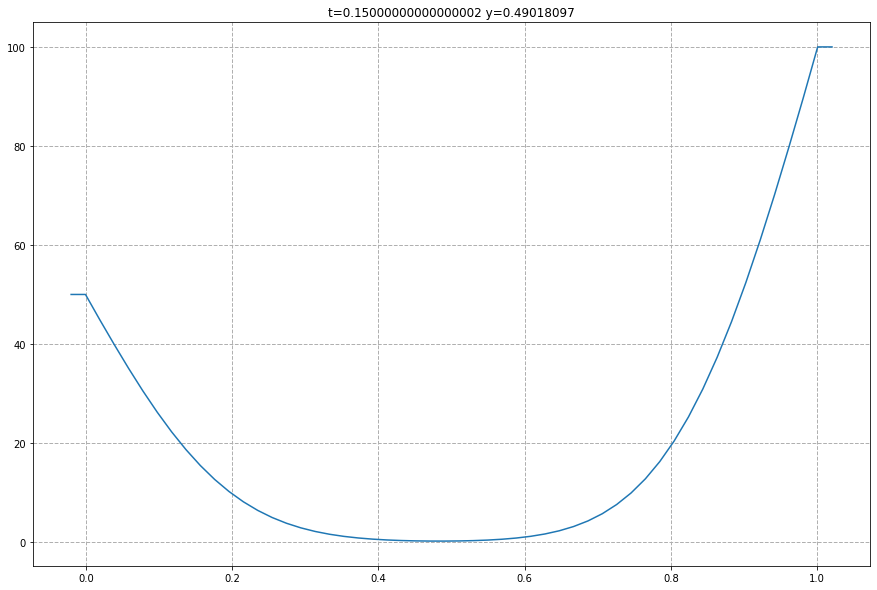

In [9]:
plot_cross(y_cross=4.9018097e-01, time=10, key='C[A]')

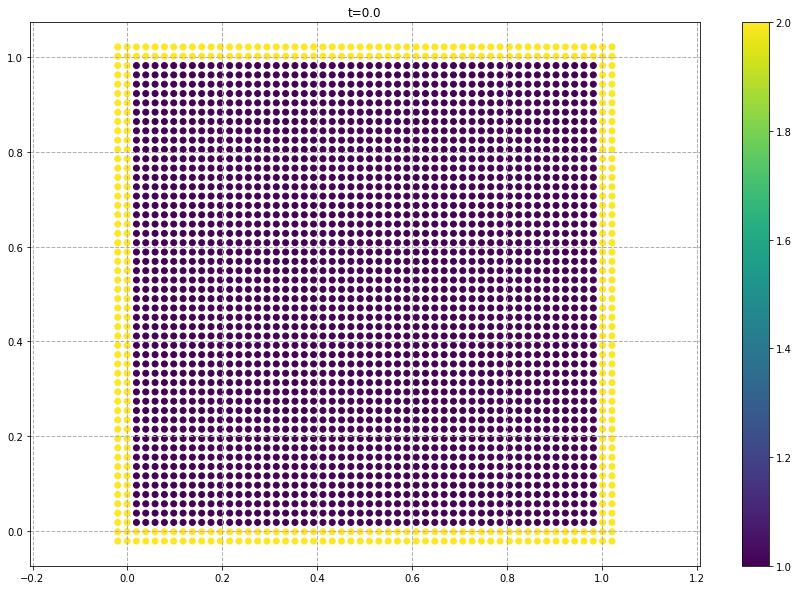

In [10]:
plot_step() # show particle types (wall, )

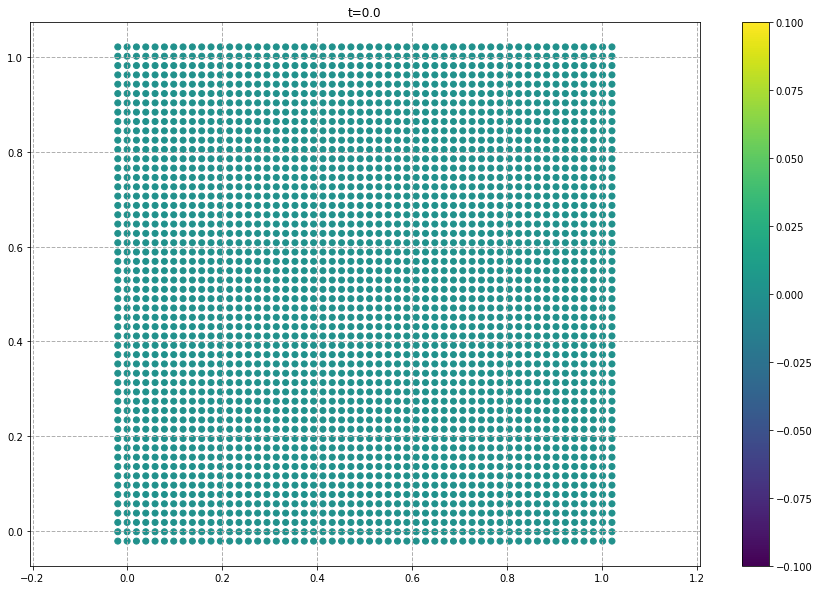

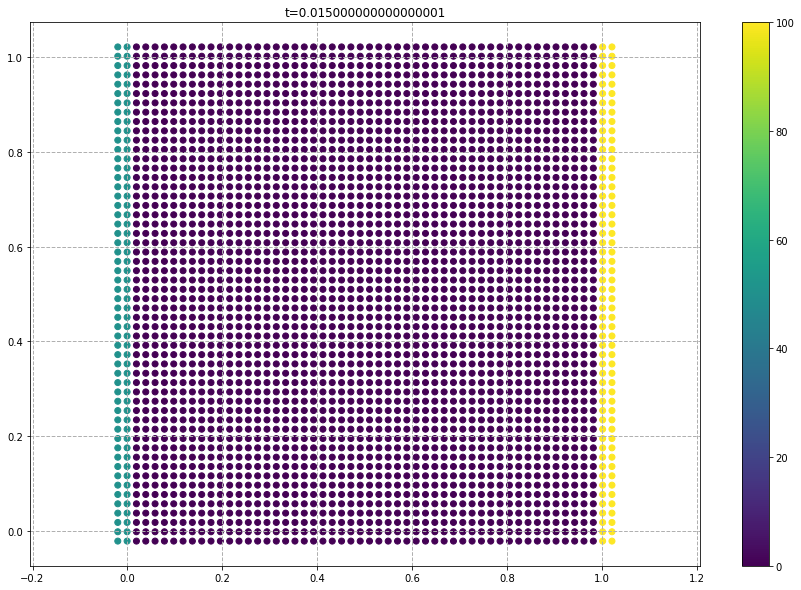

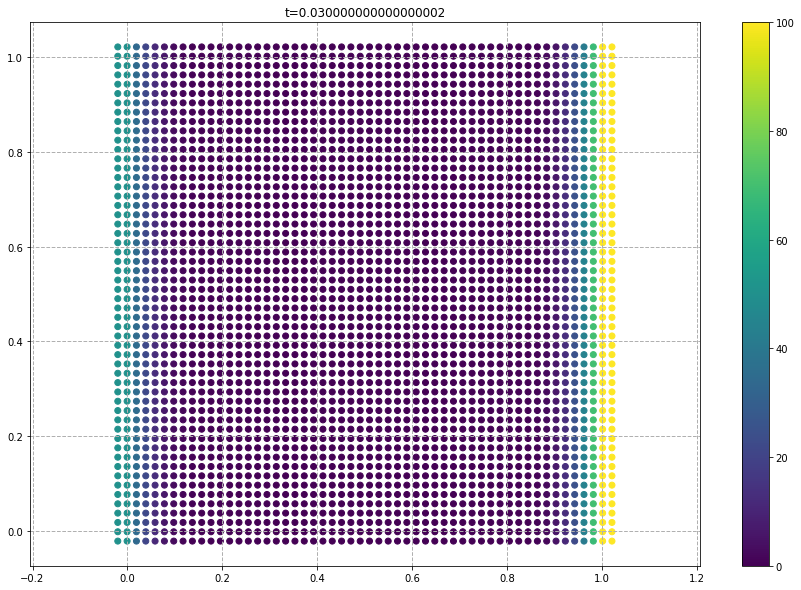

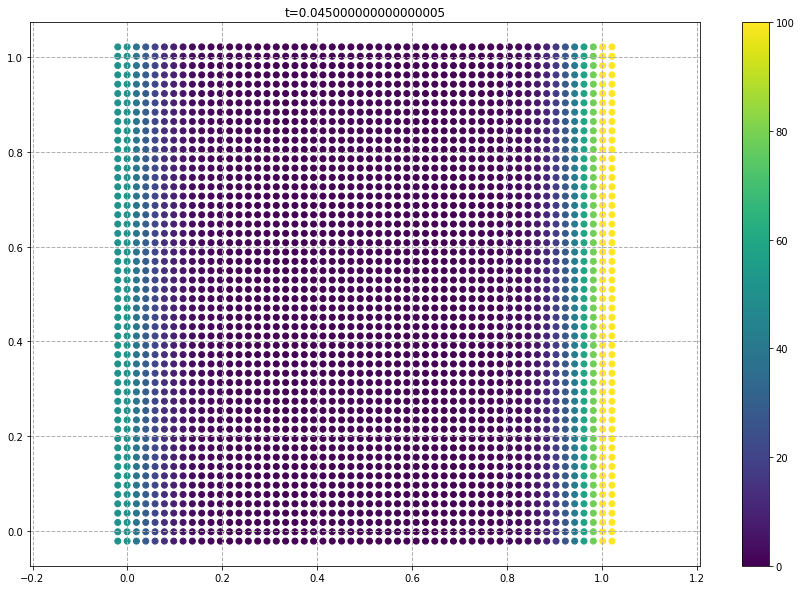

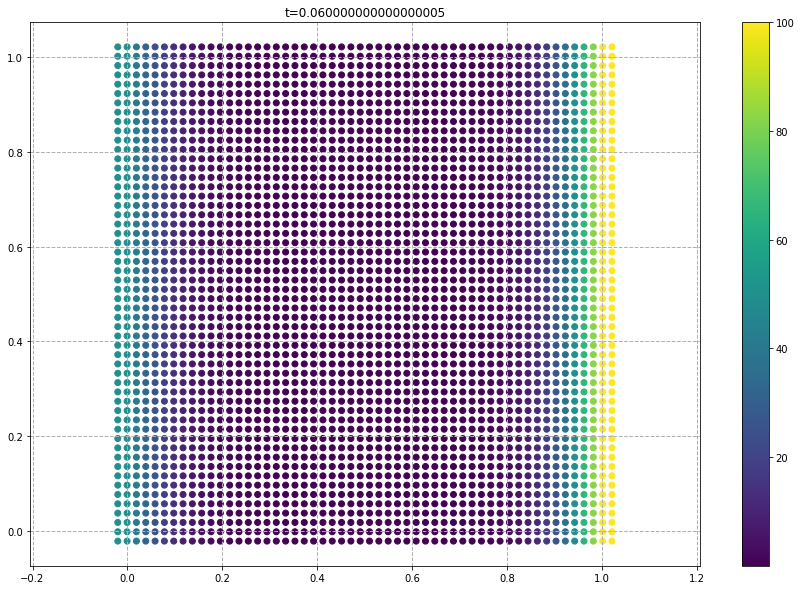

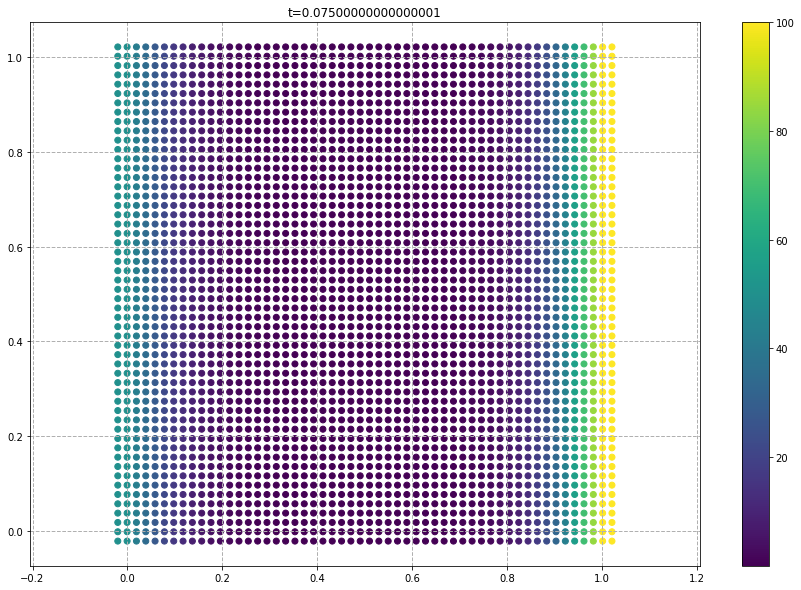

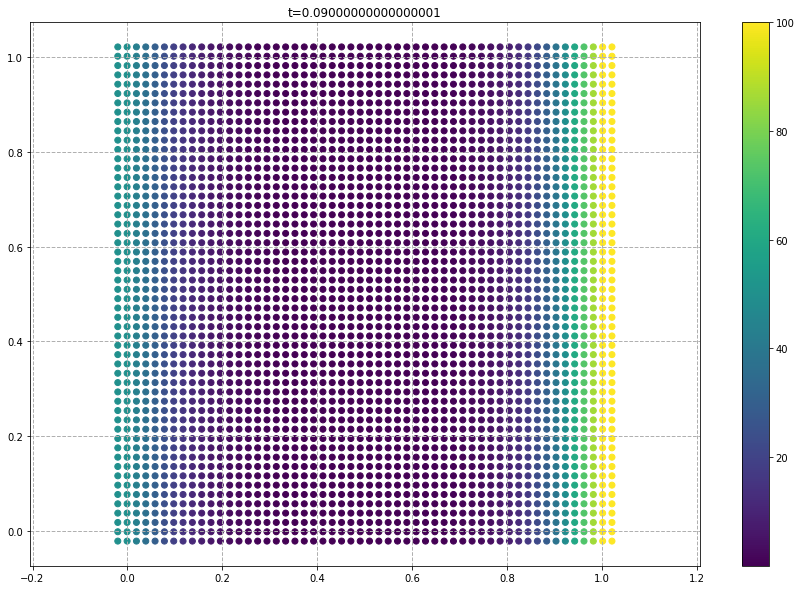

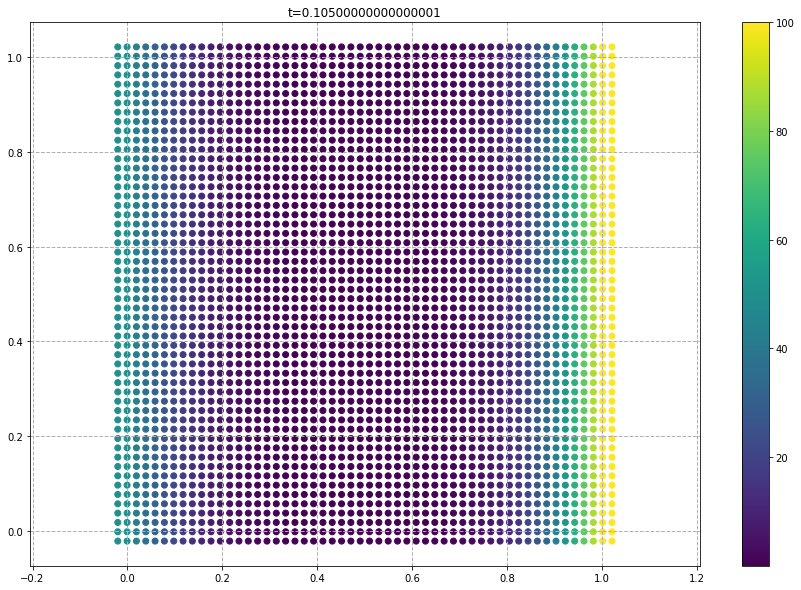

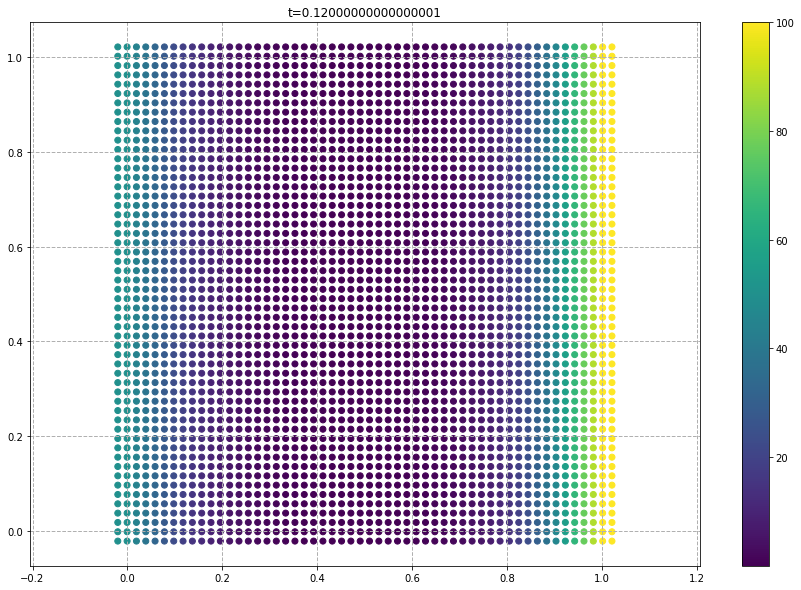

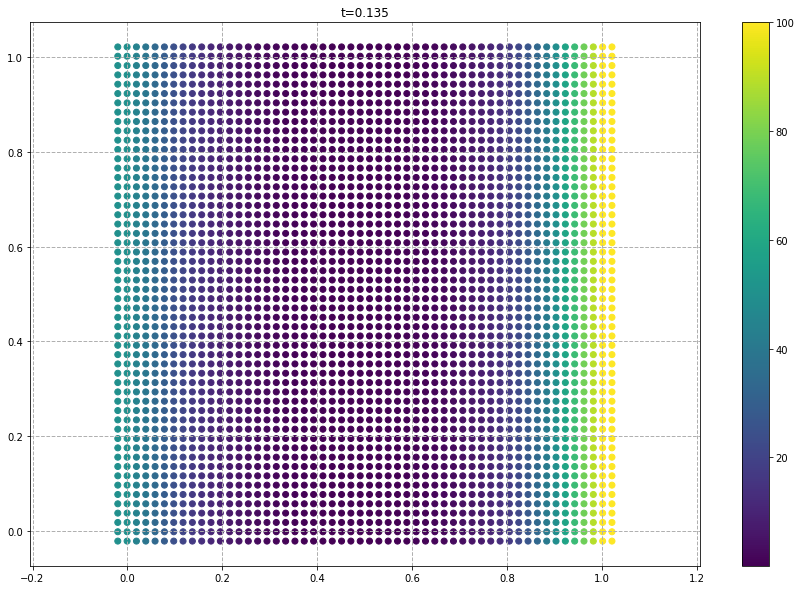

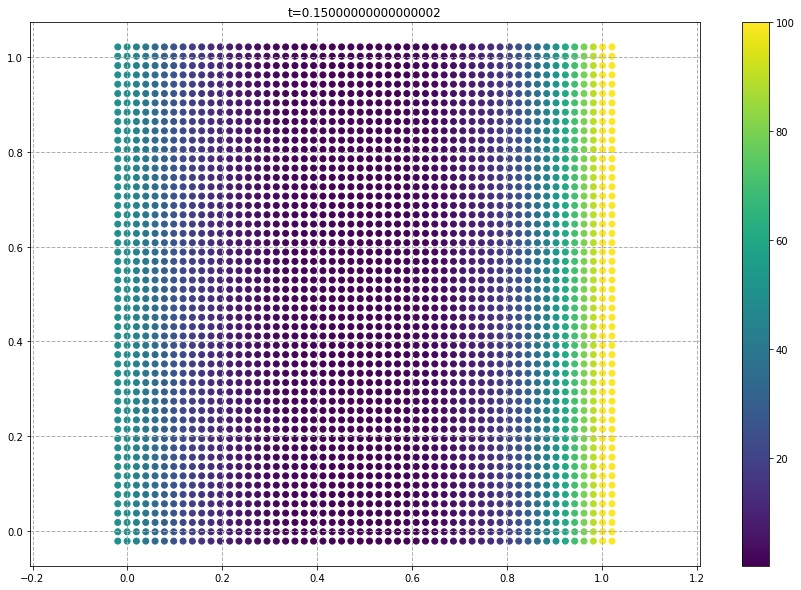

In [11]:
plot_all('C[A]')

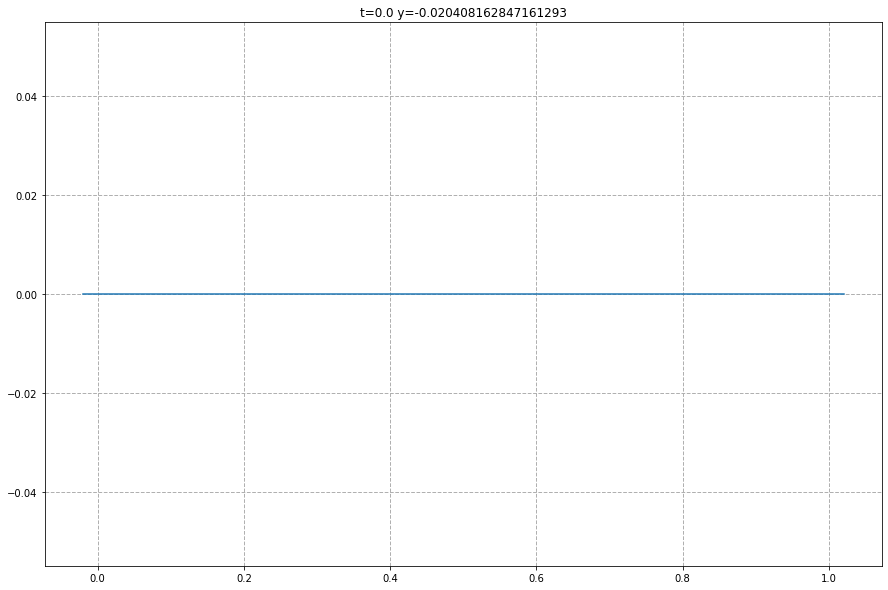

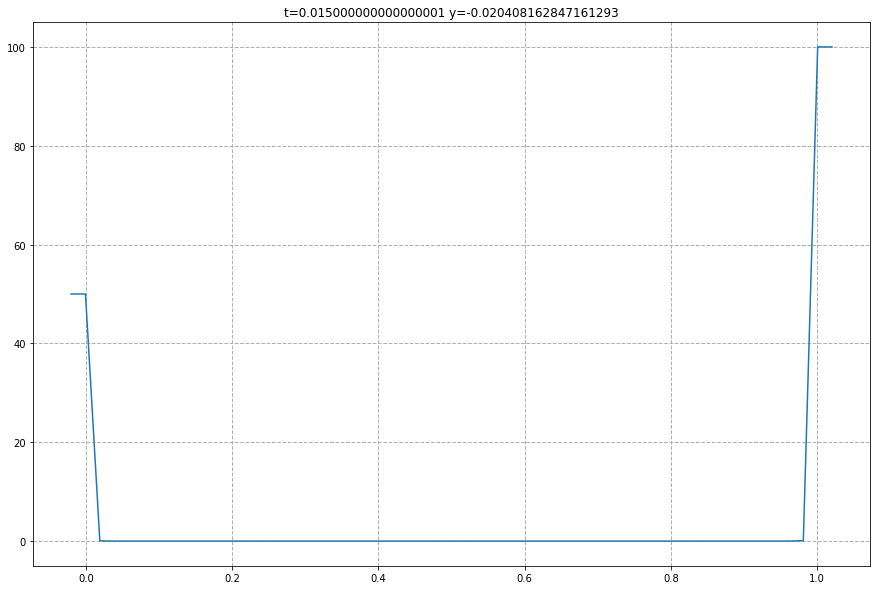

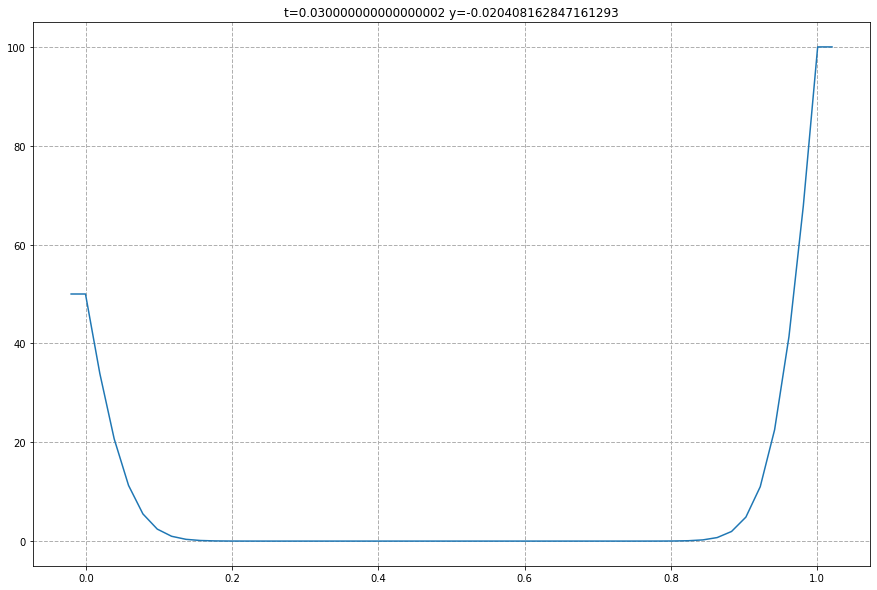

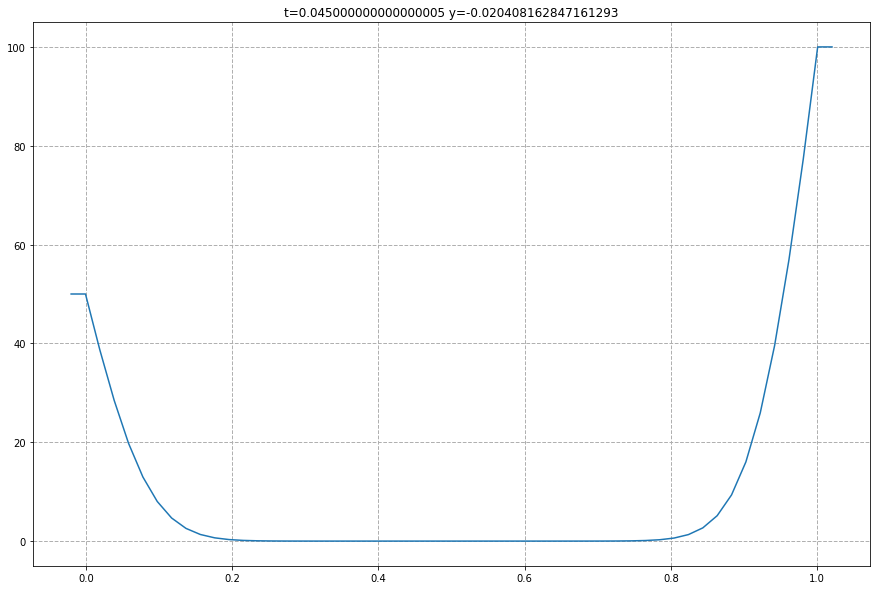

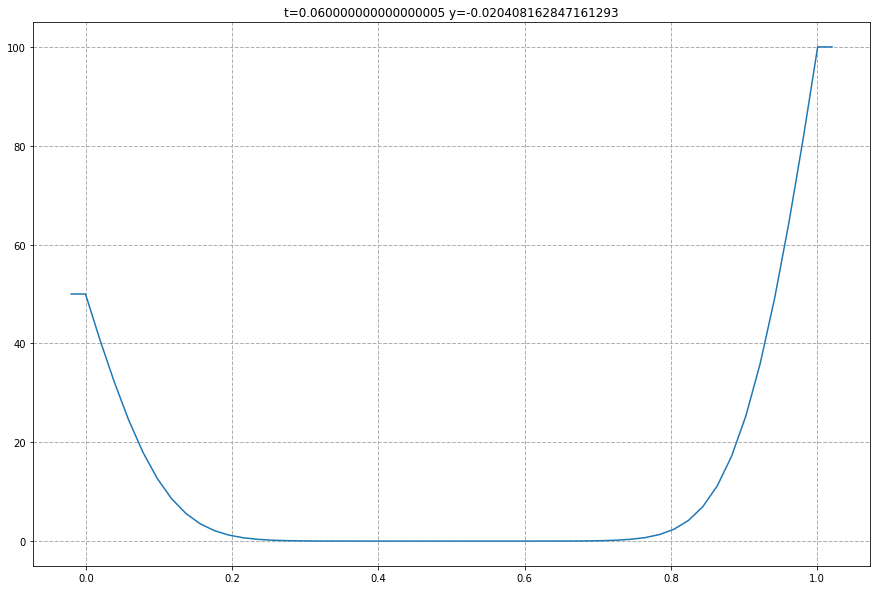

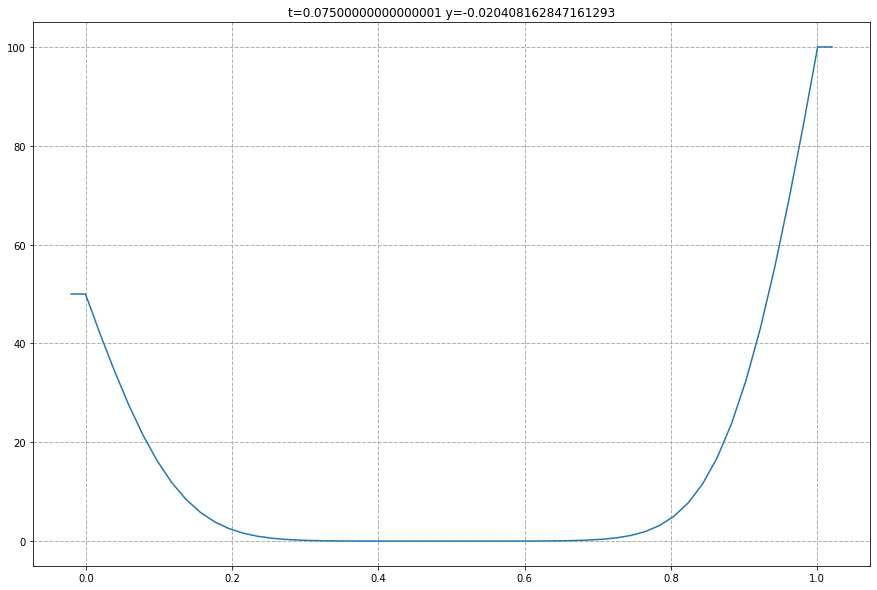

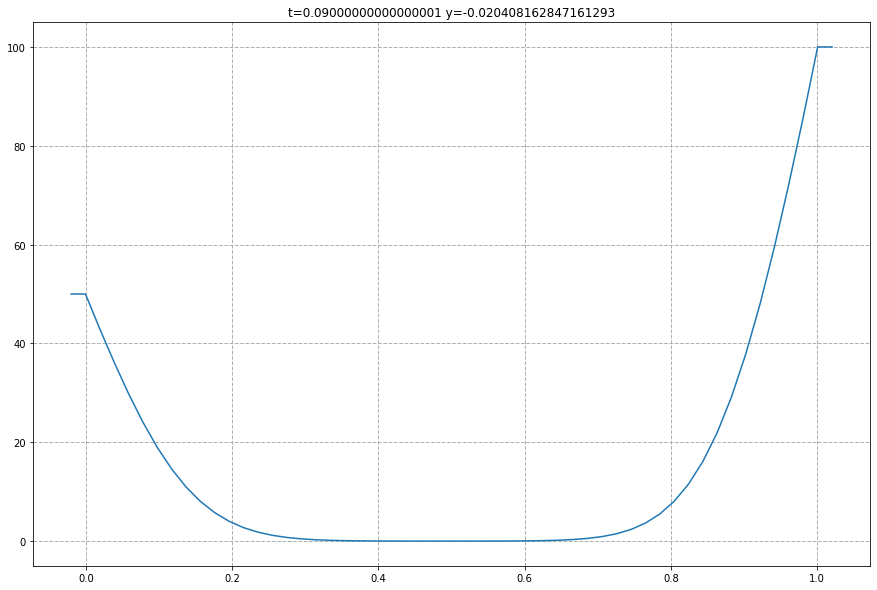

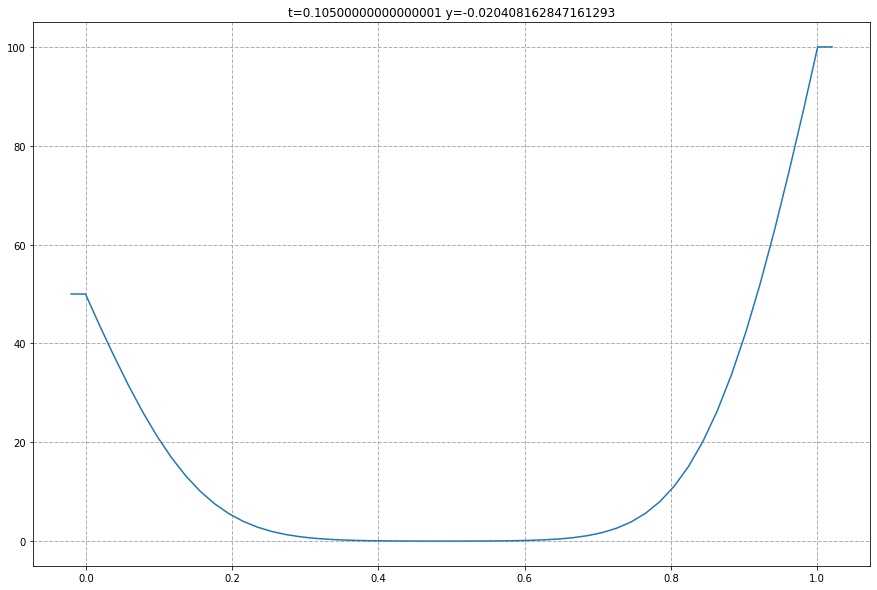

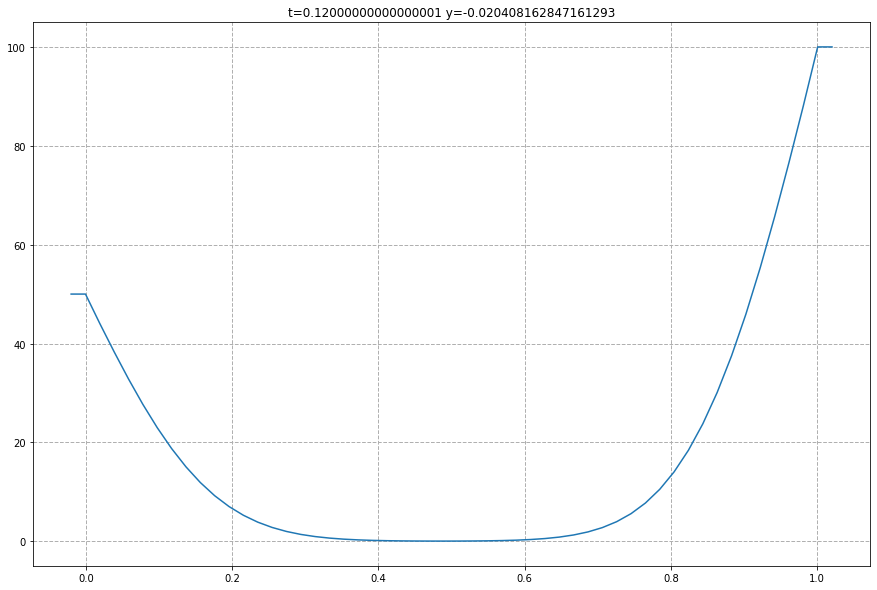

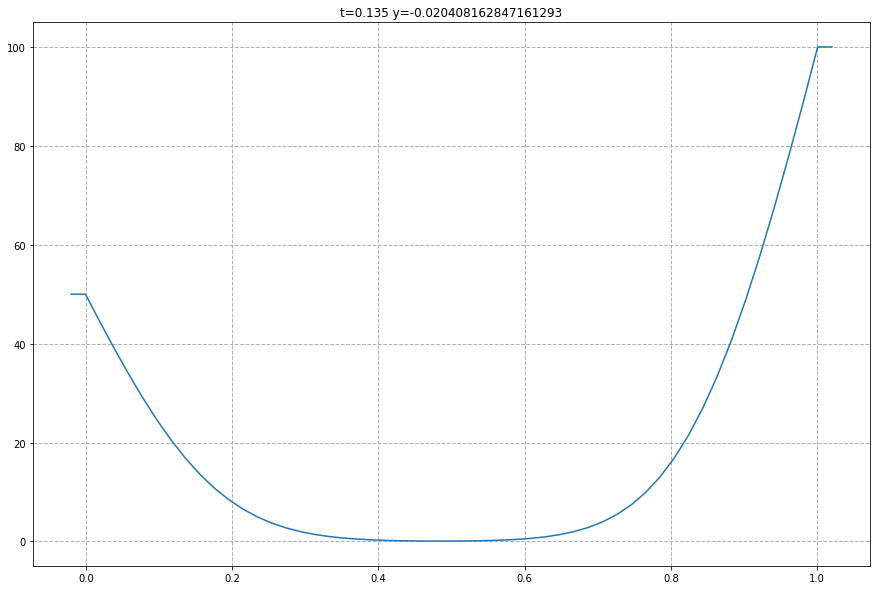

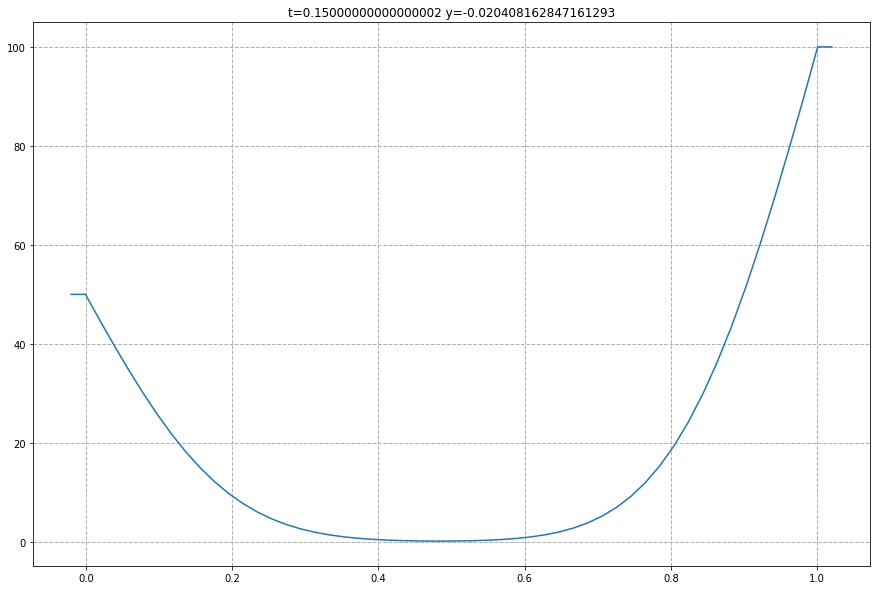

In [12]:
plot_all_cross('C[A]')

In [13]:
result.plot_species("A", -1, deterministic=True)